# Recommendations with IBM


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [1]:
# Import packages and data
import sys
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Explore distribution of how many articles a user interacts with  

In [3]:
num_articles = df['email'].value_counts()

Text(0.5,1,'Histogram of number of articles read per user')

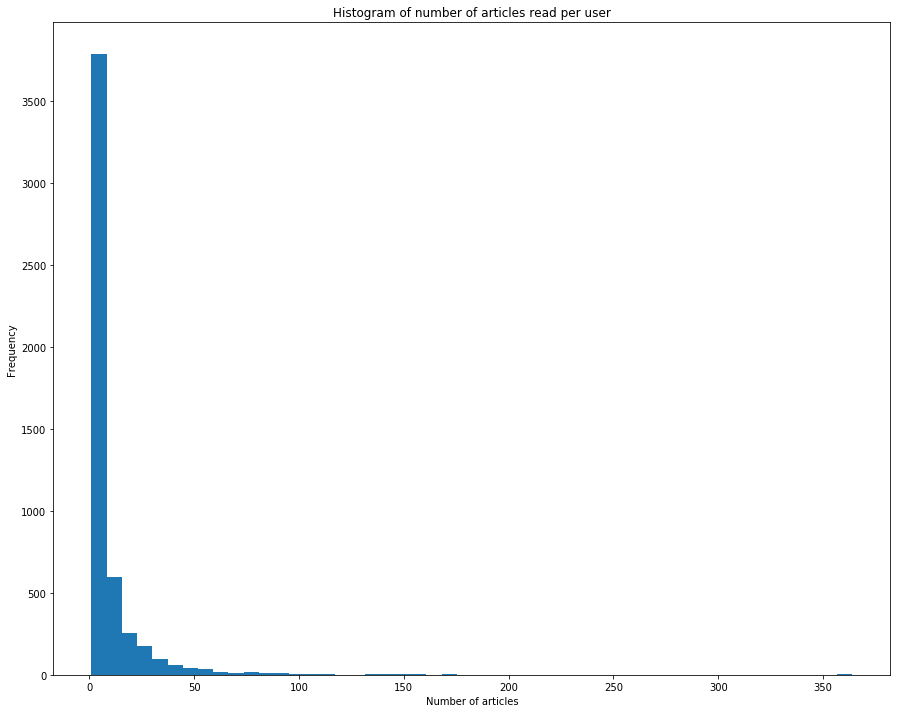

In [4]:
plt.figure(figsize=(15,12))
num_articles.plot(kind = 'hist', bins = 50)
plt.xlabel('Number of articles')
plt.title("Histogram of number of articles read per user")

In [5]:
num_articles.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

In [6]:
#50% of individuals interact with 3 number of articles or fewer
median_val = num_articles.median()

#The maximum number of user-article interactions by any 1 user is 364.
max_views_by_user = num_articles.max()

Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Find and explore duplicate articles
duplicates = df_content[df_content.duplicated()]

# Number of duplicates
duplicates.shape[0]

1534

In [8]:
# The majority of duplicates identified are missing values
duplicates.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64
17,fontsize=12),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content_clean = df_content[~df_content['article_id'].duplicated()]

In [10]:
# Create dataframe of number of readers per article
num_readers = df.groupby('article_id').count().rename(columns={"title": "count"}).reset_index()[['article_id','count']]

In [11]:
# The number of unique articles that have at least one interaction
unique_articles = num_readers.shape[0]

# The number of unique articles on the IBM platform
total_articles = df_content_clean.shape[0]

# The number of unique users
unique_users = df['email'].nunique()

# The number of user-article interactions
#user_article_interactions = np.sum(combined_df[~combined_df['count'].isna()]['count'])
user_article_interactions = df.shape[0]

In [12]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(num_readers.sort_values('count', ascending = False).iloc[0]['article_id']) + '.0'

# The most viewed article in the dataset was viewed how many times?
max_views = int(num_readers.sort_values('count', ascending = False).iloc[0]['count'])

In [13]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [14]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Rank-Based Recommendations</a>

In [15]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Calculate number of readers per article
    num_readers = df.groupby('title').count().rename(columns={"article_id": "count"}).reset_index()\
                    [['title','count']].sort_values('count', ascending = False)
    # Return top n articles names
    top_articles = list(num_readers['title'].iloc[0:n])
    
    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Calculate number of readers per article
    num_readers = df.groupby('article_id').count().rename(columns={"title": "count"}).reset_index()\
                    [['article_id','count']].sort_values('count', ascending = False)
    # Return top n articles ids
    top_articles = list(num_readers['article_id'].iloc[0:n])
 
    return top_articles # Return the top article ids

In [16]:
# Test functions
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [17]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User"> User-User Based Collaborative Filtering</a>

In [18]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Create user-article matrix
    df2 = df.groupby(['user_id', 'article_id'])['title'].max().unstack()
    
    # turn article ids into integers
    user_item = df2.notna().applymap(lambda x : int(x))
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [19]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [20]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Compute similarity of each user to the provided user
    similar_users = user_item.dot(np.transpose(user_item)[user_id])

    # Sort by similarity and create list of just the ids
    most_similar_users = list(similar_users.sort_values(ascending = False).reset_index()['user_id'])
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [21]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [22]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Make article ids integers
    article_ids = [int(float(i)) for i in article_ids]
    
    articles = df[['article_id', 'title']]
    article_names = set(articles[articles['article_id'].isin(article_ids)]['title'])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Extracts article ids for user
    article_ids = set(user_item.loc[user_id][user_item.loc[user_id] == 1].reset_index()['article_id'])
    
    # Transform article ids into string format
    article_ids = [str(i) + '.0' for i in article_ids]
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Find articles that user has read
    user_read_ids, user_read_names = get_user_articles(user_id)
    
    # Find similar users
    similar_users = find_similar_users(user_id)
    
    recs =np.array([])
    
    for user in similar_users:
        # Find articles neighbour has read
        neighbour_read_ids, neighbour_read_names = get_user_articles(user)
        
        # Find articles neighbour has read which user hasn't
        new_recs = np.setdiff1d(neighbour_read_ids, user_read_ids, assume_unique=True)
        
        # Add these new recommenations to the recomenations array
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        # If we have enough recommendations (>m) exit the loop
        if len(recs) >= m:
            break
    
    return recs[:m] # return your recommendations for this user_id    

In [23]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

{'1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'a tensorflow regression model to predict house values',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings',
 'analyze facebook data using ibm watson and watson studio',
 'data tidying in data science experience',
 'recommender systems: approaches & algorithms'}

In [24]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


In [25]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''

    # compute similarity of each user to the provided user
    similar_users = user_item.dot(np.transpose(user_item)[user_id])
    similar_users = similar_users.reset_index().rename(columns={0: "similarity"})
    
    # sort neighbours by similarity and create list of just the ids
    num_articles = df.groupby('user_id').count().rename(columns={"title": "num_interactions"}).reset_index()[['user_id','num_interactions']]
    neighbors_df = pd.merge(similar_users, num_articles, on='user_id', how='left')\
                    .sort_values(by = ['similarity', 'num_interactions'], ascending = False).rename(columns={"user_id": "neighbor_id"})
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id].reset_index(drop=True)

    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # create a list of articles read by user
    user_read_ids, user_read_names = get_user_articles(user_id)
    user_read_ids = [int(float(i)) for i in user_read_ids]
    
    # find similar users to user
    similar_users = list(get_top_sorted_users(user_id).reset_index()['neighbor_id'])
    
    # calucate number of interactions that each article id has had
    num_readers = df['article_id'].value_counts()
    
    recs = np.array([])
    
    for neighbor_id in similar_users:
        
        # Find articles that neighbour has read
        neighbor_read_ids, neighbor_read_names = get_user_articles(neighbor_id)
        
        neighbor_read_ids = [int(float(i)) for i in neighbor_read_ids]
        neighbor_articles = dict()
        
        for article_id in neighbor_read_ids:
        
            # Assign number of readers to each article id
            neighbor_articles[article_id] = num_readers[article_id]
        
        # Order dictionary so that article ids with most interactions are at the top
        sorted_neighbor_articles = {k: v for k, v in sorted(neighbor_articles.items(), reverse = True, key=lambda item: item[1])}
        sorted_neighbor_article_ids = list(sorted_neighbor_articles.keys())
        
        # Find the recommendations which the user has not already read
        new_recs = np.setdiff1d(sorted_neighbor_article_ids, user_read_ids, assume_unique=True)
        
        # Update recs array with new recs
        recs = np.concatenate([new_recs, recs], axis=0)
        
    # If we have enough recommendations (>m) exit the loop
        if len(recs) >= m:
             break
    
    # Cut number of recommendations at length =m
    recs = recs[:10]
    
    # Find names of articles
    rec_names = get_article_names(recs)

    
    return recs, rec_names



In [26]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330. 1427. 1364. 1170. 1162. 1304. 1351. 1160. 1354. 1368.]

The top 10 recommendations for user 20 are the following article names:
{'apache spark lab, part 1: basic concepts', 'analyze accident reports on amazon emr spark', 'predicting churn with the spss random tree algorithm', 'putting a human face on machine learning', 'movie recommender system with spark machine learning', 'analyze energy consumption in buildings', 'model bike sharing data with spss', 'insights from new york car accident reports', 'gosales transactions for logistic regression model', 'use xgboost, scikit-learn & ibm watson machine learning apis'}


In [27]:
### Tests with a dictionary of results
# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1).iloc[0][0]

# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).iloc[9][0]

In [28]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


The engine will struggle with the 'cold start problem' where a user is new. In these caess we can recommend the most popular articles as per below

In [29]:
new_user = '0.0'
int(float(new_user))

# Recommendations for a new user
new_user_recs = get_top_article_ids(10)
new_user_recs = [str(i) + '.0' for i in new_user_recs]

In [30]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In [31]:
# Load the matrix 
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [32]:
# Quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Perform SVD on the User-Item Matrix
u, s, vt = np.linalg.svd(user_item_matrix)

In the lesson I used decomposition from numpy on a subset of the matrix which contained a variety of ratings. 
In this situation the matrix contains only 0s and 1s, the majority of which are 0s.

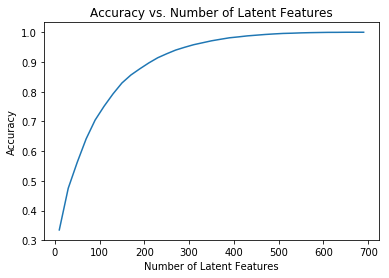

In [34]:
# Effect of increasing the number of latent features on the recommender accuracy
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [35]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Create matrices
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # Create lists of all users and articles in test dataset
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)   
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [36]:
# How many users can we make predictions for in the test set?
warm_ids = set(user_item_train.index).intersection(set(test_idx))
len(warm_ids)

20

In [37]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
user_item_test.shape[0] - len(warm_ids)

662

In [38]:
# How many articles can we make predictions for in the test set?
warm_arts = set(user_item_train.columns).intersection(set(test_arts))
len(warm_arts)

574

In [39]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
user_item_test.shape[1] - len(warm_arts)

0

In [40]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}
t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


In [41]:
# Perform SVD on the User-Item test Matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [42]:
# Find subset of rows in user_item_test df that it is possible to make predictions for
user_item_test = user_item_test.loc[warm_ids, warm_arts]

In [43]:
# Subsetting training matrices to users and articles we can make predictions for 
# N.b. don't want to create u, s and vt matrices from user_item_test as then would be training and testing model on same data
# N.b No need to subset s matrix or remaining dimensions of u and vt matrices as these correspond to number of latent features
warm_idx = user_item_train.index.isin(warm_ids)
warm_art_idx = user_item_train.columns.isin(warm_arts)
u_test = u_train[warm_idx, :]
vt_test = vt_train[:, warm_art_idx]
s_test = s_train

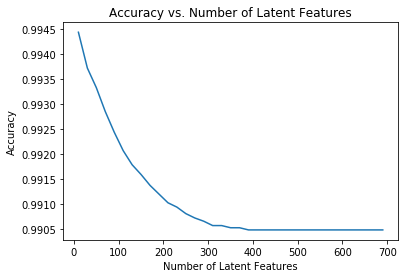

In [44]:
# Affect of increasing latent features on recommender accuracy, focusing on test data only
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_test[:k]), u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

Interestingly, the accuracy of the recommendation engine decreased when the number of latent features was increased.
On closer inspection, it doesn't appear to be users with fewest items read which are pulling down the prediction accuracy. 

In [45]:
# Are the worse errors for users who have read very few articles?
df = {'items_read': user_item_test.sum(axis=1), 'errors': abs(diffs.sum(axis=1))}
pd.DataFrame(data=df)

,items_read,errors
user_id,,
3968,8,2.0
4487,4,22.0
4231,16,3.0
3093,5,4.0
3989,1,3.0
3990,1,19.0
3740,55,20.0
3998,8,12.0
4002,10,9.0


The results are likely related to the high proportion of 'cold start' users in the dataset and therefore the difficulty to apply collaborative filtering methods. 
It is important to understand whether implementing this recommdation engine help users find new articles of interest. To do this, I would set up an AB test where users are given a cookie. Depending on the value of this cookie they are either given recommendations driven by the current set up or recommendations from this new collaborative filtering recommendation system. 
In order to measure success, KPIs would have to be agreed such as time on site or average number of articles read for example. These KPIs would then be compared between the two groups and and differences tested for significance.

In [46]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0